In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import unicodedata
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2

ModuleNotFoundError: No module named 'torch'

In [ ]:
!7z e '/content/drive/MyDrive/Project/detectron/recognition_real_dataset.tar.7z'
!mkdir recognition
!tar -xvf '/content/cropped_data.tar' -C '/content/recognition'

In [ ]:

def index_by_unicode(begin,end,start_index ):
    # convert hexadecimal string to integers
    l_range = int(begin, 16)
    u_range = int(end, 16)

    letter_index = dict()
    i = start_index
    for char_code in range(l_range, u_range + 1):
        char_index = chr(char_code)
        char_name = unicodedata.name(char_index)
        letter_index[char_name] = i
        i += 1
    return letter_index, i

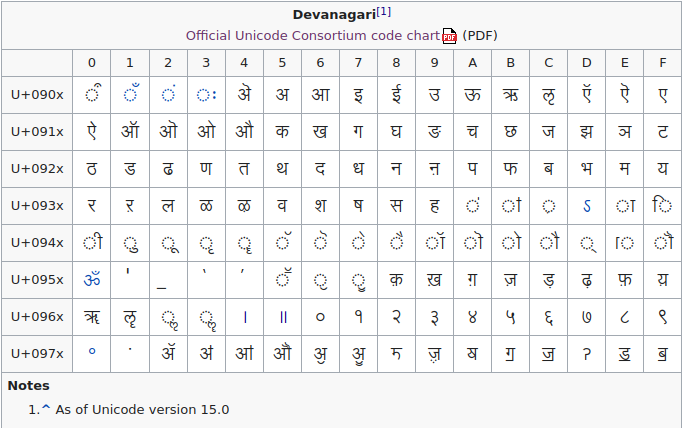

Building vocabulary for Devnagari

In [ ]:
# i=0 -> start , i=1 -> end, i=2 -> pad
i = 3
letter_index, index = index_by_unicode("0900", "094D", i)
digits, index = index_by_unicode("0966", "096F", index)
om, index = index_by_unicode("0950", "0950", index)
additional, index = index_by_unicode("0958", "095F", index)

letter_index.update(digits)
letter_index.update(om)
letter_index.update(additional)

In [ ]:
letter_index

Function to convert character into numerical index

In [ ]:
def get_labels(text, letter_index):
    labels = list()
    for char in text:
        name = unicodedata.name(char)
        index = letter_index[name]
        labels.append(index)
    return labels

In [ ]:
annotation_path = '/content/recognition/cropped_data/annotations.txt'
with open(annotation_path) as file:

    labels = list()
    for line in file.readlines():
        hindi_text = line.split('\t')[1].strip()
        print(hindi_text)
        try:
            labels.append(get_labels(hindi_text, letter_index))
        except KeyError:
            pass
    # find max length of name for padding
    max_len = max([len(label) for label in labels]) + 2  # including start and stop symbols

In [ ]:
labels

In [ ]:
cols = ['name', 'text', 'labels', 'unpadded_length'] # Features
annotation_df = pd.DataFrame()
with open(annotation_path) as file:
    data = {}
    for line in tqdm(file.readlines()):
        img_path, hindi_text = line.split('\t')[:2]
        img_path = img_path.strip()
        hindi_text = hindi_text.strip()
        data['name'] = img_path
        data['text'] = f"<start> {hindi_text} <stop>"
        label = [0]  ## Initialize with the <start> token
        try:
            label.extend(get_labels(hindi_text, letter_index))
        except KeyError:
            continue
        label.append(1)  ## End with the <stop> token
        data['unpadded_length'] = int(len(label))
        extra_padding = max_len - len(label)
        label.extend([2] * extra_padding)
        data['labels'] = label
        annotation_df = annotation_df.append(data, ignore_index=True)

100%|██████████| 1740/1740 [00:04<00:00, 416.14it/s]


In [ ]:
annotation_df.head()

,name,text,unpadded_length,labels
0,cropped_dir/0.jpg,<start> जल <stop>,4.0,"[0, 31, 53, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2..."
1,cropped_dir/1.jpg,<start> शोध <stop>,5.0,"[0, 57, 78, 42, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,cropped_dir/2.jpg,<start> न <stop>,3.0,"[0, 43, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
3,cropped_dir/3.jpg,<start> संयंत्र <stop>,9.0,"[0, 59, 5, 50, 5, 39, 80, 51, 1, 2, 2, 2, 2, 2..."
4,cropped_dir/4.jpg,<start> बिना <stop>,6.0,"[0, 47, 66, 43, 65, 1, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [ ]:
annotation_df.to_pickle('/content/annot.pkl')
annotation_df.to_csv('/content/annot.csv')

In [ ]:
# Splitting into train & test data
train_df, test_df = train_test_split(annotation_df, test_size=0.10, random_state= 0, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.05, random_state= 0, shuffle=True)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1487, 4)
(79, 4)
(174, 4)


In [ ]:
class Hindi_DataLoader(Dataset):
    def __init__(self, root_directory,df=None, transform=None):
        self.transform = transform
        self.annotation_df = df
        self.images = [] # List of images to be recognized
        self.labels = [] # List of index tensors fro each word
        self.unpadded_length = [] # List of actual length of word: <start><word><stop>

        for index in tqdm(range(len(self.annotation_df))):
            row = self.annotation_df.iloc[index]
            image_path = os.path.join(root_directory, row['name'])
            img = cv2.imread(image_path)
            try:
                img = Image.fromarray(img)
            except:
                continue
            self.images.append(img)
            self.labels.append(torch.as_tensor(row['labels'], dtype=torch.long))
            self.unpadded_length.append(torch.as_tensor(row['unpadded_length'], dtype=torch.long))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        char_length = self.unpadded_length[index]
        if self.transform:
            image = self.transform(image)
        return image,label, char_length


In [ ]:
"""Inception-v3 will work with size >= 299 x 299 during training
when aux_logits is True, otherwise it can work with size as small as 75 x 75."""
def get_transform(train=False):
    T = list()
    T.append(transforms.Resize((299, 299)))  # image size input for inception_v3
    T.append(transforms.ToTensor())
    return transforms.Compose(T)

In [ ]:
root_directory = '/content/recognition/cropped_data'
train_dataset = Hindi_DataLoader(root_directory,df=train_df,transform=get_transform(train=True))
val_dataset = Hindi_DataLoader(root_directory,df=val_df, transform=get_transform())
test_dataset = Hindi_DataLoader(root_directory, df=test_df, transform=get_transform())

  0%|          | 0/1487 [00:00<?, ?it/s]<ipython-input-13-bf0a92bad537>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.unpadded_length.append(torch.as_tensor(row['unpadded_length'], dtype=torch.long))
100%|██████████| 174/174 [00:00<00:00, 509.48it/s]


tensor([ 0, 43, 26, 51,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])


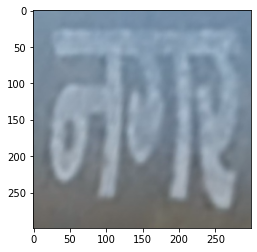

In [ ]:
sample_img, sample_label,sample_length = train_dataset[5]
print(sample_label)
plt.imshow(sample_img.permute(1,2,0))


The freeze_layer variable is assumed to contain the name of a layer in the model that you want to keep trainable.

E.g, if you want to keep the weights of the layer Mixed_7c.branch_pool.conv trainable, you would set freeze_layer to 'Mixed_7c.branch_pool.conv'.

Function iterates through all the parameters in the model and sets the requires_grad attribute to False for all parameters except those that belong to the layer specified in freeze_layer.

Finally, a new classifier block is defined and set as the last layer of the model.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.encoder = models.inception_v3(pretrained=True)
        self.encoder.aux_logits = False

        self.encoder.fc = nn.Linear(in_features=2048, out_features=output_size, bias=False)

        # Freeze the model params except the classifier block of the network
        freeze_layer = 'Mixed_7c.branch_pool.conv.weight'
        for name, param in self.encoder.named_parameters():
            if name == freeze_layer:
                break
            param.requires_grad = False

    def forward(self, input):
        output = self.encoder(input).cuda()
        return output

pack_padded_sequence:

Padded elements are removed and replaced with a single tensor that contains only the non-zero elements

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, pad_id, num_layers=1, dropout=0, bi=False):
        super().__init__()
        self.pad_id = pad_id
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=self.pad_id)
        self.gru= nn.GRU(hidden_size, hidden_size, num_layers=num_layers, bias=False, batch_first=True, dropout=dropout, bidirectional=bi)

        if bi is True:
            hidden_size = 2 * hidden_size
        self.linear = nn.Linear(hidden_size, output_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden_state, lengths):
        embedding = self.embedding(input)
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False).cuda()
        output,h_state = self.gru(packed_seq, hidden_state)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.linear(output)
        output = self.softmax(output)
        return output, h_state

In [ ]:
# Hyperparameters
epochs = 10
log_step = 20 # Interval for average loss calculation
batch_size = 32
num_workers = 4 # Four workers will simulataneously put data into RAM
encoder_out = 1024 # size output tensor from inceptionV3
encoder_lr = 0.001
sequence_len = 16
hidden_size = encoder_out
output_size = 100
decoder_lr =  0.001
bidirectional = False
dropout = 0.3
num_layers = 3
num_directions = 2 if bidirectional else 1

In [ ]:
# pytorch data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Loss criteria
loss = nn.NLLLoss() # Negative log likelihood loss
sos_id = 0
eos_id = 1
pad_id = 2
# Model and optimizer variables
encoder = Encoder(encoder_out).cuda()
encoder_optim = torch.optim.Adam(encoder.parameters(), lr=encoder_lr)

decoder = Decoder(hidden_size, output_size, pad_id, num_layers=num_layers, dropout=dropout, bi=bidirectional).cuda()
decoder_optim = torch.optim.Adam(decoder.parameters(), lr=decoder_lr)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
def train_epoch(loader,encoder,decoder,encoder_optim,decoder_optim,criterion, log_step = 10):

    loss_profile = []
    eos = 1
    for step, (images, labels, lengths) in enumerate(loader):
        batch_size = lengths.size()[0]
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()
        images = images.cuda()
        labels = labels.cuda()
        context = encoder(images).cuda()
        context = context.view(1,-1,encoder_out)
        context = torch.cat([context]*(num_directions*num_layers),dim = 0)
        hidden_state = context
        loss = 0
        decoder_output, hn_state = decoder(labels,hidden_state,lengths)
        max_seq_size = decoder_output.size()[1]
        loss_mask = torch.zeros(batch_size,max_seq_size,device= "cuda")

        for i in range(batch_size):
            length = lengths[i].item()
            loss_mask[i,:length] = 1
        for i in range(max_seq_size-1):
            mask = loss_mask[:,i].view(-1,1)
            output = decoder_output[:,i,:]
            output = output*mask
            loss+=criterion(output,labels[:,i+1])
        loss.backward()
        decoder_optim.step()
        encoder_optim.step()
        loss_profile.append(loss.item())
        if step % log_step == 0:
            print(f"Training Loss: {loss.item()}")
    return loss_profile

In [ ]:
loss_profile = []
dec_lr_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optim, step_size=10, gamma=0.1)
enc_lr_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optim, step_size=10, gamma=0.1)

# Training

In [ ]:
encoder.train()
decoder.train()
for epoch_idx in range(epochs):
    print(f'Epoch: {epoch_idx + 1}')
    epoch_loss = train_epoch(train_loader, encoder, decoder, encoder_optim, decoder_optim, loss, log_step=log_step)
    loss_profile.extend(epoch_loss)
    dec_lr_scheduler.step()
    enc_lr_scheduler.step()

Epoch: 1
Training Loss: 1.8694921731948853
Training Loss: 3.2389914989471436
Training Loss: 2.356821060180664
Epoch: 2
Training Loss: 1.7903999090194702
Training Loss: 1.8181462287902832
Training Loss: 2.3725697994232178
Epoch: 3
Training Loss: 1.7215238809585571
Training Loss: 2.1028597354888916
Training Loss: 1.940555214881897
Epoch: 4
Training Loss: 1.50065016746521
Training Loss: 1.6593475341796875
Training Loss: 1.7599579095840454
Epoch: 5
Training Loss: 2.0760014057159424
Training Loss: 1.90554940700531
Training Loss: 1.8772236108779907
Epoch: 6
Training Loss: 1.778896450996399
Training Loss: 1.8008842468261719
Training Loss: 2.038205623626709
Epoch: 7
Training Loss: 1.6180483102798462
Training Loss: 1.6309860944747925
Training Loss: 1.3114714622497559
Epoch: 8
Training Loss: 2.01863956451416
Training Loss: 1.7460068464279175
Training Loss: 1.582862377166748
Epoch: 9
Training Loss: 1.3826746940612793
Training Loss: 1.4858322143554688
Training Loss: 1.5744198560714722
Epoch: 10
Tr

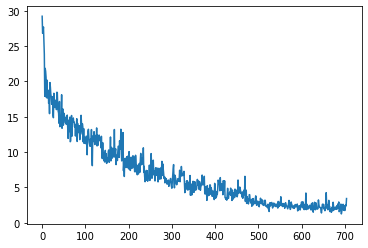

In [ ]:
plt.plot(loss_profile)

In [ ]:
def predict(image, encoder, decoder, sos_id, eos_id):
    # Put the models in the evaluation mode
    max_seq_len = sequence_len

    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        context = encoder(image)
        context = context.view(1, -1, encoder_out)

        context = torch.cat([context] * (num_directions * num_layers) , dim=0)
        # hidden_state = (context, torch.zeros(context.shape).cuda())
        hidden_state = context
        input = torch.as_tensor([[sos_id]], dtype=torch.long).cuda()
        values = []
        indices = []
        for i in range(max_seq_len):
            decoder_output, hidden_state = decoder(input, hidden_state, torch.as_tensor([1], dtype=torch.long, device='cpu'))
            preds = decoder_output.view(-1, output_size)
            preds = torch.topk(preds, 1)
            value, index = preds.values, preds.indices.item()
            values.extend(torch.exp(value))
            indices.append(index)
            input = preds.indices

            if index == eos_id:
                break
    return values, indices

tensor([ 0, 48, 65, 51, 39, 67, 50,  1,  2,  2,  2,  2,  2,  2,  2,  2])
[0.38268646597862244, 0.45560452342033386, 0.8173116445541382, 0.4018910229206085, 0.9307236671447754, 0.9138729572296143]
[8, 43, 80, 41, 51, 1]


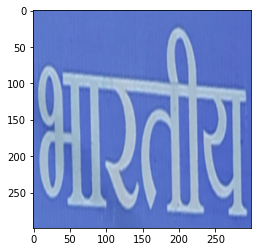

In [ ]:
encoder.eval()
decoder.eval()

image, label, _ = val_dataset[10]
plt.imshow(image.permute(1,2,0))
print(label)

# get the predictions
values, indices = predict(image, encoder, decoder, 0, 1)
print([value.item() for value in values])
print(indices)